# Baseline DQN Training on Standard Lunar Lander

This notebook trains a Deep Q-Network (DQN) agent on the standard Lunar Lander environment.

**Goal**: Verify that our DQN implementation works before moving to multi-task learning.

**Success Criteria**:
- Agent learns to land successfully (reward > 200)
- Training curves show steady improvement
- Can save and load trained model

---

## 1. Setup: Imports and Environment

In [1]:
# Add parent directory to path to import our modules
import sys
sys.path.append('..')

import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Our custom modules
from environments import make_env
from agents import DQNAgent
from utils import ReplayBuffer

# Enable inline plotting for Jupyter
%matplotlib inline

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All imports successful!
PyTorch version: 2.5.1
CUDA available: False


/opt/anaconda3/envs/mtrl/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
# Create environment
env = make_env('standard', render_mode=None)

# Get environment info
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"Environment: {env.task_name} Lunar Lander")
print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"\nActions: 0=nothing, 1=left engine, 2=main engine, 3=right engine")

Environment: Standard Lunar Lander
State dimension: 8
Action dimension: 4

Actions: 0=nothing, 1=left engine, 2=main engine, 3=right engine


## 2. Hyperparameters

These hyperparameters control the training process. You can experiment with different values!

In [3]:
# Training hyperparameters
HYPERPARAMS = {
    # Training
    'num_episodes': 1000,           # Total episodes to train
    'batch_size': 64,               # Batch size for training
    'replay_buffer_size': 100000,   # Size of experience replay buffer
    'min_replay_size': 1000,        # Start training after this many experiences
    
    # DQN Agent
    'learning_rate': 5e-4,          # Learning rate (0.0005)
    'gamma': 0.99,                  # Discount factor
    'epsilon_start': 1.0,           # Initial exploration rate
    'epsilon_end': 0.01,            # Final exploration rate
    'epsilon_decay': 0.995,         # Epsilon decay per episode
    'target_update_freq': 10,       # Update target network every N episodes
    
    # Evaluation
    'eval_freq': 50,                # Evaluate every N episodes
    'eval_episodes': 5,             # Number of episodes for evaluation
    
    # Checkpointing
    'save_freq': 100,               # Save model every N episodes
    'model_path': '../results/models/baseline_dqn.pth'
}

# Device (use GPU if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
HYPERPARAMS['device'] = device

# Print hyperparameters
print("Hyperparameters:")
print("=" * 60)
for key, value in HYPERPARAMS.items():
    print(f"  {key:<25} {value}")
print("=" * 60)

Hyperparameters:
  num_episodes              1000
  batch_size                64
  replay_buffer_size        100000
  min_replay_size           1000
  learning_rate             0.0005
  gamma                     0.99
  epsilon_start             1.0
  epsilon_end               0.01
  epsilon_decay             0.995
  target_update_freq        10
  eval_freq                 50
  eval_episodes             5
  save_freq                 100
  model_path                ../results/models/baseline_dqn.pth
  device                    cpu


## 3. Initialize Agent and Replay Buffer

In [4]:
# Create DQN agent
agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    learning_rate=HYPERPARAMS['learning_rate'],
    gamma=HYPERPARAMS['gamma'],
    epsilon_start=HYPERPARAMS['epsilon_start'],
    epsilon_end=HYPERPARAMS['epsilon_end'],
    epsilon_decay=HYPERPARAMS['epsilon_decay'],
    target_update_freq=HYPERPARAMS['target_update_freq'],
    device=device
)

# Create replay buffer
replay_buffer = ReplayBuffer(capacity=HYPERPARAMS['replay_buffer_size'])

print(f"✓ Created: {agent}")
print(f"✓ Created: {replay_buffer}")

✓ Created: DQNAgent(state_dim=8, action_dim=4, epsilon=1.0000, steps=0)
✓ Created: ReplayBuffer(capacity=100000, size=0)


## 4. Training Loop with Text Progress

This cell will train the agent and display text-based progress showing:
- Episode rewards (how well the agent is doing)
- Steps per episode
- Training loss (how well the network is fitting)
- Epsilon (exploration rate)
- Running average reward (last 100 episodes)

All metrics are saved after training for later visualization.

**Note**: Training may take 10-30 minutes depending on your hardware.

In [5]:
import time

# Helper function for incremental metrics saving
def save_progress_checkpoint(rewards, losses, eval_rewards, eval_episodes):
    """Save training progress during training (every 50 episodes)"""
    import json
    import os
    os.makedirs('../results/logs', exist_ok=True)
    checkpoint_data = {
        'episode_rewards': rewards,
        'episode_losses': losses,
        'eval_rewards': eval_rewards,
        'eval_episodes': eval_episodes,
        'last_episode': len(rewards),
        'timestamp': time.strftime("%Y%m%d_%H%M%S")
    }
    with open('../results/logs/baseline_dqn_progress.json', 'w') as f:
        json.dump(checkpoint_data, f, indent=2)

# Function to count model parameters
def count_parameters(model):
    """Count total and trainable parameters in a PyTorch model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'total': total_params, 'trainable': trainable_params}

# Count parameters in DQN networks
q_network_params = count_parameters(agent.q_network)
target_network_params = count_parameters(agent.target_network)
total_model_params = q_network_params['total'] + target_network_params['total']

print("=" * 80)
print("MODEL PARAMETER COUNTS (Parameter Efficiency Metric)")
print("=" * 80)
print(f"Q-Network:      {q_network_params['total']:,} total, {q_network_params['trainable']:,} trainable")
print(f"Target Network: {target_network_params['total']:,} total, {target_network_params['trainable']:,} trainable")
print(f"Total:          {total_model_params:,} parameters")
print("=" * 80)
print()

# Training statistics
episode_rewards = []
episode_losses = []
eval_rewards = []
eval_episodes = []

# Sample Efficiency Metrics
total_env_steps = 0              # Total environment steps taken
total_gradient_updates = 0       # Total gradient updates performed
performance_thresholds = {       # Track when thresholds are first reached
    50: None,    # Moderate performance
    100: None,   # Good performance
    150: None,   # Very good performance
    200: None,   # Success threshold (solved)
}

# Best model tracking
best_eval_reward = -np.inf

# Track training time
start_time = time.time()

print("🚀 Starting training...")
print("💡 Progress bar will update below. Check it to monitor training status!\n")

# Initialize progress bar
pbar = tqdm(total=HYPERPARAMS['num_episodes'], desc="Training DQN",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

# Training loop
for episode in range(HYPERPARAMS['num_episodes']):
    state, info = env.reset()
    episode_reward = 0
    episode_loss = []
    done = False
    truncated = False
    steps = 0
    
    # Play one episode
    while not (done or truncated):
        # Select action using epsilon-greedy
        action = agent.select_action(state)
        
        # Take action in environment
        next_state, reward, done, truncated, info = env.step(action)
        
        # Store transition in replay buffer
        replay_buffer.push(state, action, reward, next_state, done)
        
        # Train if we have enough experiences
        if len(replay_buffer) >= HYPERPARAMS['min_replay_size']:
            batch = replay_buffer.sample(HYPERPARAMS['batch_size'])
            loss = agent.update(batch)
            episode_loss.append(loss)
            total_gradient_updates += 1  # Track gradient updates
        
        episode_reward += reward
        state = next_state
        steps += 1
        total_env_steps += 1  # Track total environment steps
    
    # Decay epsilon after each episode
    agent.decay_epsilon()
    agent.episodes += 1
    
    # Update target network
    if episode % agent.target_update_freq == 0:
        agent.update_target_network()
    
    # Store statistics
    episode_rewards.append(episode_reward)
    avg_loss = np.mean(episode_loss) if episode_loss else 0
    episode_losses.append(avg_loss)
    
    # Calculate running average
    avg_reward_100 = np.mean(episode_rewards[-100:]) if episode_rewards else 0
    
    # Check performance thresholds (Sample Efficiency Metric)
    for threshold, first_episode in performance_thresholds.items():
        if first_episode is None and avg_reward_100 >= threshold:
            performance_thresholds[threshold] = {
                'episode': episode + 1,
                'total_steps': total_env_steps,
                'gradient_updates': total_gradient_updates
            }
            pbar.write(f"🎯 Threshold reached! Avg reward {threshold} at episode {episode+1} (steps: {total_env_steps:,}, updates: {total_gradient_updates:,})")
    
    # Update progress bar with current metrics
    pbar.set_postfix({
        'reward': f'{episode_reward:.1f}',
        'avg_100': f'{avg_reward_100:.1f}',
        'ε': f'{agent.epsilon:.3f}',
        'loss': f'{avg_loss:.2f}'
    })
    pbar.update(1)
    
    # Print summary every 100 episodes
    if (episode + 1) % 100 == 0:
        pbar.write(f"\n[Episode {episode+1:4d}] Reward: {episode_reward:7.2f} | Avg(100): {avg_reward_100:7.2f} | Loss: {avg_loss:6.4f} | ε: {agent.epsilon:.3f}")
        pbar.write(f"               Steps: {total_env_steps:,} | Gradient Updates: {total_gradient_updates:,}")
    
    # Save progress checkpoint every 50 episodes
    if (episode + 1) % 50 == 0:
        save_progress_checkpoint(episode_rewards, episode_losses, eval_rewards, eval_episodes)
    
    # Evaluation
    if episode % HYPERPARAMS['eval_freq'] == 0 and episode > 0:
        eval_reward_mean = 0
        eval_reward_list = []
        
        for _ in range(HYPERPARAMS['eval_episodes']):
            eval_state, _ = env.reset()
            eval_reward = 0
            eval_done = False
            eval_truncated = False
            
            while not (eval_done or eval_truncated):
                eval_action = agent.select_action(eval_state, epsilon=0.0)  # Greedy
                eval_state, r, eval_done, eval_truncated, _ = env.step(eval_action)
                eval_reward += r
            
            eval_reward_list.append(eval_reward)
            eval_reward_mean += eval_reward
        
        eval_reward_mean /= HYPERPARAMS['eval_episodes']
        eval_reward_std = np.std(eval_reward_list)
        eval_rewards.append(eval_reward_mean)
        eval_episodes.append(episode)
        
        # Print evaluation results (using pbar.write)
        pbar.write("-" * 80)
        if eval_reward_mean > best_eval_reward:
            best_eval_reward = eval_reward_mean
            agent.save(HYPERPARAMS['model_path'])
            pbar.write(f"[EVAL @ Episode {episode+1}] Mean: {eval_reward_mean:7.2f} (±{eval_reward_std:5.2f}) | Best: {best_eval_reward:7.2f} ⭐ NEW BEST!")
        else:
            pbar.write(f"[EVAL @ Episode {episode+1}] Mean: {eval_reward_mean:7.2f} (±{eval_reward_std:5.2f}) | Best: {best_eval_reward:7.2f}")
        pbar.write("-" * 80)
    
    # Checkpoint
    if episode % HYPERPARAMS['save_freq'] == 0 and episode > 0:
        checkpoint_path = HYPERPARAMS['model_path'].replace('.pth', f'_ep{episode}.pth')
        agent.save(checkpoint_path)
        pbar.write(f"[CHECKPOINT] Saved model to {checkpoint_path}")

# Close progress bar
pbar.close()

# Calculate total training time
training_time = time.time() - start_time

print("\n" + "=" * 80)
print("✅ Training complete!")
print("=" * 80)
print(f"Total training time: {training_time/60:.2f} minutes ({training_time:.1f} seconds)")
print(f"Best evaluation reward: {best_eval_reward:.2f}")
print(f"Final average reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.2f}")
print()
print("SAMPLE EFFICIENCY METRICS:")
print(f"  Total environment steps: {total_env_steps:,}")
print(f"  Total gradient updates: {total_gradient_updates:,}")
print(f"  Steps per episode (avg): {total_env_steps / len(episode_rewards):.1f}")
print()
print("PERFORMANCE THRESHOLDS REACHED:")
for threshold in sorted(performance_thresholds.keys()):
    milestone = performance_thresholds[threshold]
    if milestone:
        print(f"  Reward ≥ {threshold:3d}: Episode {milestone['episode']:4d} | Steps: {milestone['total_steps']:,} | Updates: {milestone['gradient_updates']:,}")
    else:
        print(f"  Reward ≥ {threshold:3d}: Not reached")
print("=" * 80)

MODEL PARAMETER COUNTS (Parameter Efficiency Metric)
Q-Network:      35,716 total, 35,716 trainable
Target Network: 35,716 total, 35,716 trainable
Total:          71,432 parameters

🚀 Starting training...
💡 Progress bar will update below. Check it to monitor training status!



Training DQN:   5%|█▉                                    | 52/1000 [00:05<03:20]

--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn.pth
[EVAL @ Episode 51] Mean: -269.91 (±94.56) | Best: -269.91 ⭐ NEW BEST!
--------------------------------------------------------------------------------


Training DQN:  10%|███▋                                 | 101/1000 [00:13<02:04]


[Episode  100] Reward:  -68.97 | Avg(100): -118.59 | Loss: 23.6339 | ε: 0.606
               Steps: 11,686 | Gradient Updates: 10,687


Training DQN:  10%|███▍                              | 102/1000 [05:30<23:49:09]

--------------------------------------------------------------------------------
[EVAL @ Episode 101] Mean: -114380.24 (±228166.40) | Best: -269.91
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep100.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep100.pth


Training DQN:  15%|█████▌                               | 151/1000 [08:05<09:47]

--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn.pth
[EVAL @ Episode 151] Mean: -116.50 (±22.34) | Best: -116.50 ⭐ NEW BEST!
--------------------------------------------------------------------------------


Training DQN:  20%|███████▍                             | 200/1000 [10:57<03:51]


[Episode  200] Reward:  -29.87 | Avg(100): -356.56 | Loss: 2.8407 | ε: 0.367
               Steps: 268,991 | Gradient Updates: 267,992


Training DQN:  20%|███████▍                             | 202/1000 [10:57<03:42]

--------------------------------------------------------------------------------
[EVAL @ Episode 201] Mean: -149.52 (±89.73) | Best: -116.50
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep200.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep200.pth


Training DQN:  25%|█████████▎                           | 251/1000 [11:09<03:28]

--------------------------------------------------------------------------------
[EVAL @ Episode 251] Mean: -183.83 (±139.61) | Best: -116.50
--------------------------------------------------------------------------------


Training DQN:  30%|███████████▏                         | 301/1000 [12:28<18:50]


[Episode  300] Reward:  -49.75 | Avg(100): -131.84 | Loss: 6.3442 | ε: 0.222
               Steps: 331,295 | Gradient Updates: 330,296


Training DQN:  30%|███████████▏                         | 301/1000 [12:28<18:50]

--------------------------------------------------------------------------------
[EVAL @ Episode 301] Mean: -520.93 (±48.37) | Best: -116.50
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep300.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep300.pth


Training DQN:  35%|████████████▉                        | 351/1000 [13:40<28:22]

--------------------------------------------------------------------------------
[EVAL @ Episode 351] Mean: -297.49 (±106.65) | Best: -116.50
--------------------------------------------------------------------------------


Training DQN:  40%|██████████████▊                      | 401/1000 [14:52<10:11]


[Episode  400] Reward: -393.58 | Avg(100): -266.57 | Loss: 7.8067 | ε: 0.135
               Steps: 438,722 | Gradient Updates: 437,723


Training DQN:  40%|██████████████▊                      | 401/1000 [14:53<10:11]

--------------------------------------------------------------------------------
[EVAL @ Episode 401] Mean: -591.35 (±501.50) | Best: -116.50
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep400.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep400.pth


Training DQN:  45%|████████████████▋                    | 451/1000 [15:28<11:43]

--------------------------------------------------------------------------------
[EVAL @ Episode 451] Mean: -233.61 (±154.02) | Best: -116.50
--------------------------------------------------------------------------------


Training DQN:  50%|██████████████████▌                  | 500/1000 [16:21<09:02]


[Episode  500] Reward: -116.68 | Avg(100):  -61.05 | Loss: 12.1230 | ε: 0.082
               Steps: 503,973 | Gradient Updates: 502,974


Training DQN:  50%|██████████████████▌                  | 501/1000 [16:21<07:32]

--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn.pth
[EVAL @ Episode 501] Mean:  121.80 (±163.15) | Best:  121.80 ⭐ NEW BEST!
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep500.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep500.pth


Training DQN:  55%|████████████████████▍                | 551/1000 [16:57<03:50]

🎯 Threshold reached! Avg reward 50 at episode 551 (steps: 530,651, updates: 529,652)
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn.pth
[EVAL @ Episode 551] Mean:  150.97 (±174.24) | Best:  150.97 ⭐ NEW BEST!
--------------------------------------------------------------------------------


Training DQN:  57%|████████████████████▉                | 566/1000 [17:04<02:37]

🎯 Threshold reached! Avg reward 100 at episode 566 (steps: 535,707, updates: 534,708)


Training DQN:  60%|██████████████████████               | 597/1000 [17:17<03:25]

🎯 Threshold reached! Avg reward 150 at episode 597 (steps: 545,743, updates: 544,744)


Training DQN:  60%|██████████████████████▏              | 600/1000 [17:19<04:13]


[Episode  600] Reward:  173.16 | Avg(100):  159.07 | Loss: 22.0134 | ε: 0.049
               Steps: 547,095 | Gradient Updates: 546,096


Training DQN:  60%|██████████████████████▏              | 601/1000 [17:20<03:45]

--------------------------------------------------------------------------------
[EVAL @ Episode 601] Mean:   61.13 (±231.46) | Best:  150.97
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep600.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep600.pth


Training DQN:  63%|███████████████████████▎             | 629/1000 [17:35<05:35]

🎯 Threshold reached! Avg reward 200 at episode 629 (steps: 558,357, updates: 557,358)


Training DQN:  65%|████████████████████████             | 651/1000 [17:46<03:26]

--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn.pth
[EVAL @ Episode 651] Mean:  172.24 (±130.67) | Best:  172.24 ⭐ NEW BEST!
--------------------------------------------------------------------------------


Training DQN:  70%|█████████████████████████▉           | 700/1000 [18:30<03:53]


[Episode  700] Reward:  256.24 | Avg(100):  215.09 | Loss: 21.7788 | ε: 0.030
               Steps: 598,557 | Gradient Updates: 597,558


Training DQN:  70%|█████████████████████████▉           | 701/1000 [18:40<05:25]

--------------------------------------------------------------------------------
[EVAL @ Episode 701] Mean:  -16.40 (±248.01) | Best:  172.24
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep700.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep700.pth


Training DQN:  75%|███████████████████████████▊         | 751/1000 [19:11<01:41]

--------------------------------------------------------------------------------
[EVAL @ Episode 751] Mean:  167.49 (±148.69) | Best:  172.24
--------------------------------------------------------------------------------


Training DQN:  80%|█████████████████████████████▌       | 800/1000 [19:33<01:38]


[Episode  800] Reward:  251.22 | Avg(100):  220.90 | Loss: 16.2512 | ε: 0.018
               Steps: 637,708 | Gradient Updates: 636,709


Training DQN:  80%|█████████████████████████████▋       | 801/1000 [19:34<01:35]

--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn.pth
[EVAL @ Episode 801] Mean:  185.20 (±75.98) | Best:  185.20 ⭐ NEW BEST!
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep800.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep800.pth


Training DQN:  85%|███████████████████████████████▍     | 851/1000 [19:55<00:42]

--------------------------------------------------------------------------------
[EVAL @ Episode 851] Mean:  148.16 (±132.70) | Best:  185.20
--------------------------------------------------------------------------------


Training DQN:  90%|█████████████████████████████████▎   | 900/1000 [20:14<00:35]


[Episode  900] Reward:  283.16 | Avg(100):  215.03 | Loss: 20.1577 | ε: 0.011
               Steps: 665,100 | Gradient Updates: 664,101


Training DQN:  90%|█████████████████████████████████▎   | 901/1000 [20:22<00:33]

--------------------------------------------------------------------------------
[EVAL @ Episode 901] Mean:   21.16 (±393.82) | Best:  185.20
--------------------------------------------------------------------------------
Model saved to: ../results/models/baseline_dqn_ep900.pth
[CHECKPOINT] Saved model to ../results/models/baseline_dqn_ep900.pth


Training DQN:  95%|███████████████████████████████████▏ | 951/1000 [21:08<00:16]

--------------------------------------------------------------------------------
[EVAL @ Episode 951] Mean: -1325.87 (±3165.45) | Best:  185.20
--------------------------------------------------------------------------------


Training DQN: 100%|████████████████████████████████████| 1000/1000 [21:25<00:00]


[Episode 1000] Reward:  279.20 | Avg(100):  246.04 | Loss: 28.3012 | ε: 0.010
               Steps: 687,696 | Gradient Updates: 686,697

✅ Training complete!
Total training time: 21.44 minutes (1286.1 seconds)
Best evaluation reward: 185.20
Final average reward (last 100 episodes): 246.04

SAMPLE EFFICIENCY METRICS:
  Total environment steps: 687,696
  Total gradient updates: 686,697
  Steps per episode (avg): 687.7

PERFORMANCE THRESHOLDS REACHED:
  Reward ≥  50: Episode  551 | Steps: 530,651 | Updates: 529,652
  Reward ≥ 100: Episode  566 | Steps: 535,707 | Updates: 534,708
  Reward ≥ 150: Episode  597 | Steps: 545,743 | Updates: 544,744
  Reward ≥ 200: Episode  629 | Steps: 558,357 | Updates: 557,358


## 4b. Save Training Metrics

Save all training metrics to files for later analysis and visualization.

In [6]:
import json
import pickle
import os

# Create logs directory if it doesn't exist
os.makedirs('../results/logs', exist_ok=True)

# Prepare metrics dictionary with ALL evaluation metrics
metrics = {
    # Basic training metrics
    "hyperparams": HYPERPARAMS,
    "episode_rewards": episode_rewards,
    "episode_losses": episode_losses,
    "eval_rewards": eval_rewards,
    "eval_episodes": eval_episodes,
    "training_time": training_time,
    "best_eval_reward": best_eval_reward,
    "timestamp": time.strftime("%Y%m%d_%H%M%S"),
    
    # PARAMETER EFFICIENCY METRICS
    "parameter_efficiency": {
        "q_network_params": q_network_params['total'],
        "target_network_params": target_network_params['total'],
        "total_params": total_model_params,
        "trainable_params": q_network_params['trainable'],
    },
    
    # SAMPLE EFFICIENCY METRICS
    "sample_efficiency": {
        "total_env_steps": total_env_steps,
        "total_gradient_updates": total_gradient_updates,
        "steps_per_episode_avg": total_env_steps / len(episode_rewards),
        "gradient_updates_per_episode_avg": total_gradient_updates / len(episode_rewards),
        "performance_thresholds": performance_thresholds,  # Episodes/steps/updates to reach thresholds
    },
    
    # CONFLICT ROBUSTNESS METRICS (for single task baseline)
    "conflict_robustness": {
        "average_reward": float(np.mean(episode_rewards)),
        "average_reward_last_100": float(np.mean(episode_rewards[-100:])),
        "per_task_reward": {
            "standard": float(np.mean(episode_rewards[-100:]))  # Single task for baseline
        }
    }
}

# Save as JSON (human-readable)
json_path = '../results/logs/baseline_dqn_metrics.json'
with open(json_path, 'w') as f:
    json.dump(metrics, f, indent=2)

# Save as pickle (preserves exact data types)
pickle_path = '../results/logs/baseline_dqn_metrics.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(metrics, f)

print("=" * 80)
print("✓ Metrics saved successfully!")
print("=" * 80)
print(f"  - JSON: {json_path}")
print(f"  - Pickle: {pickle_path}")
print()
print("SAVED METRICS SUMMARY:")
print(f"  Basic Training:")
print(f"    - {len(episode_rewards)} episode rewards")
print(f"    - {len(episode_losses)} episode losses")
print(f"    - {len(eval_rewards)} evaluation rewards")
print(f"    - Training time: {training_time/60:.2f} minutes")
print(f"    - Best eval reward: {best_eval_reward:.2f}")
print()
print(f"  Parameter Efficiency:")
print(f"    - Total parameters: {total_model_params:,}")
print(f"    - Trainable parameters: {q_network_params['trainable']:,}")
print()
print(f"  Sample Efficiency:")
print(f"    - Total environment steps: {total_env_steps:,}")
print(f"    - Total gradient updates: {total_gradient_updates:,}")
print(f"    - Avg steps/episode: {total_env_steps / len(episode_rewards):.1f}")
print()
print(f"  Conflict Robustness:")
print(f"    - Average reward: {np.mean(episode_rewards):.2f}")
print(f"    - Average reward (last 100): {np.mean(episode_rewards[-100:]):.2f}")
print("=" * 80)

✓ Metrics saved successfully!
  - JSON: ../results/logs/baseline_dqn_metrics.json
  - Pickle: ../results/logs/baseline_dqn_metrics.pkl

SAVED METRICS SUMMARY:
  Basic Training:
    - 1000 episode rewards
    - 1000 episode losses
    - 19 evaluation rewards
    - Training time: 21.44 minutes
    - Best eval reward: 185.20

  Parameter Efficiency:
    - Total parameters: 71,432
    - Trainable parameters: 35,716

  Sample Efficiency:
    - Total environment steps: 687,696
    - Total gradient updates: 686,697
    - Avg steps/episode: 687.7

  Conflict Robustness:
    - Average reward: 12.15
    - Average reward (last 100): 246.04


## 5. Evaluation: Test the Trained Agent

Let's evaluate the trained agent over multiple episodes and see how well it performs.

/Users/mithileshr/RL/notebooks/../agents/dqn.py:326: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=self.device)


Model loaded from: ../results/models/baseline_dqn.pth


Evaluating: 100%|█████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]



Final Evaluation Results
Mean reward: 207.65 ± 226.44
Min reward: -1786.52
Max reward: 291.21

Successful landings (reward > 200): 92/100


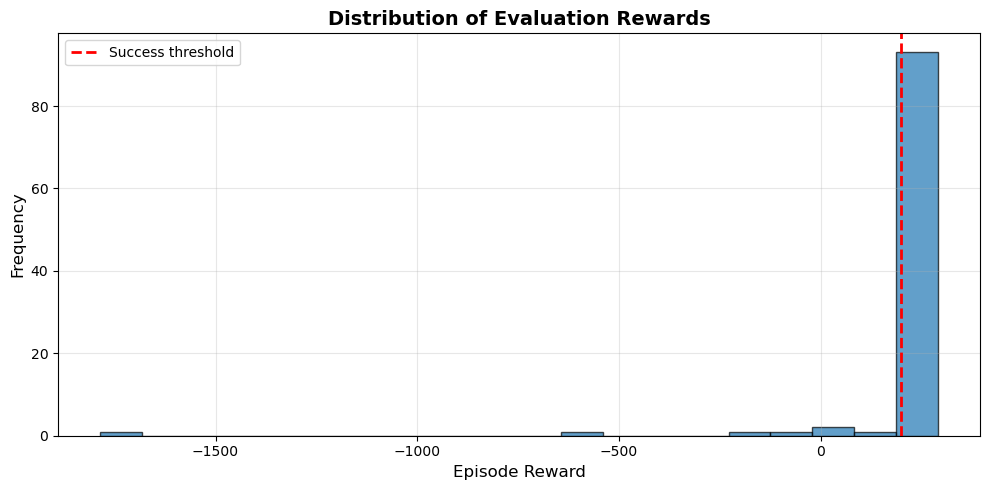

In [7]:
# Load best model
agent.load(HYPERPARAMS['model_path'])

# Evaluate
num_eval_episodes = 100
eval_rewards_final = []

for i in tqdm(range(num_eval_episodes), desc="Evaluating"):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    truncated = False
    
    while not (done or truncated):
        action = agent.select_action(state, epsilon=0.0)  # Greedy policy
        state, reward, done, truncated, _ = env.step(action)
        episode_reward += reward
    
    eval_rewards_final.append(episode_reward)

# Print statistics
print("\n" + "=" * 60)
print("Final Evaluation Results")
print("=" * 60)
print(f"Mean reward: {np.mean(eval_rewards_final):.2f} ± {np.std(eval_rewards_final):.2f}")
print(f"Min reward: {np.min(eval_rewards_final):.2f}")
print(f"Max reward: {np.max(eval_rewards_final):.2f}")
print(f"\nSuccessful landings (reward > 200): {sum(r > 200 for r in eval_rewards_final)}/{num_eval_episodes}")

# Plot distribution
plt.figure(figsize=(10, 5))
plt.hist(eval_rewards_final, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(200, color='red', linestyle='--', linewidth=2, label='Success threshold')
plt.xlabel('Episode Reward', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Evaluation Rewards', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/plots/baseline_eval_distribution.png', dpi=150)
plt.show()

## 6. Visualization: Watch the Trained Agent

Let's visualize the agent playing! (This will open a pygame window)

In [8]:
# Create environment with rendering
env_render = make_env('standard', render_mode='human')

# Play a few episodes
num_render_episodes = 3

for episode in range(num_render_episodes):
    state, _ = env_render.reset()
    episode_reward = 0
    done = False
    truncated = False
    
    print(f"\nPlaying episode {episode + 1}/{num_render_episodes}...")
    
    while not (done or truncated):
        action = agent.select_action(state, epsilon=0.0)  # Greedy
        state, reward, done, truncated, _ = env_render.step(action)
        episode_reward += reward
    
    print(f"  Episode reward: {episode_reward:.2f}")

env_render.close()
print("\nVisualization complete!")


Playing episode 1/3...
  Episode reward: 288.75

Playing episode 2/3...
  Episode reward: 228.10

Playing episode 3/3...
  Episode reward: 204.05

Visualization complete!


## 7. Analysis: Training Curves

Let's create a comprehensive plot of the training progress.

## 8. Visualization from Saved Metrics (Re-runnable)

This cell loads the saved metrics and creates comprehensive visualizations. You can re-run this cell anytime without re-training!

✓ Metrics loaded successfully!
  Episodes: 1000
  Training time: 21.44 minutes
  Best eval reward: 185.20

✓ Plot saved to: ../results/plots/baseline_dqn_comprehensive.png


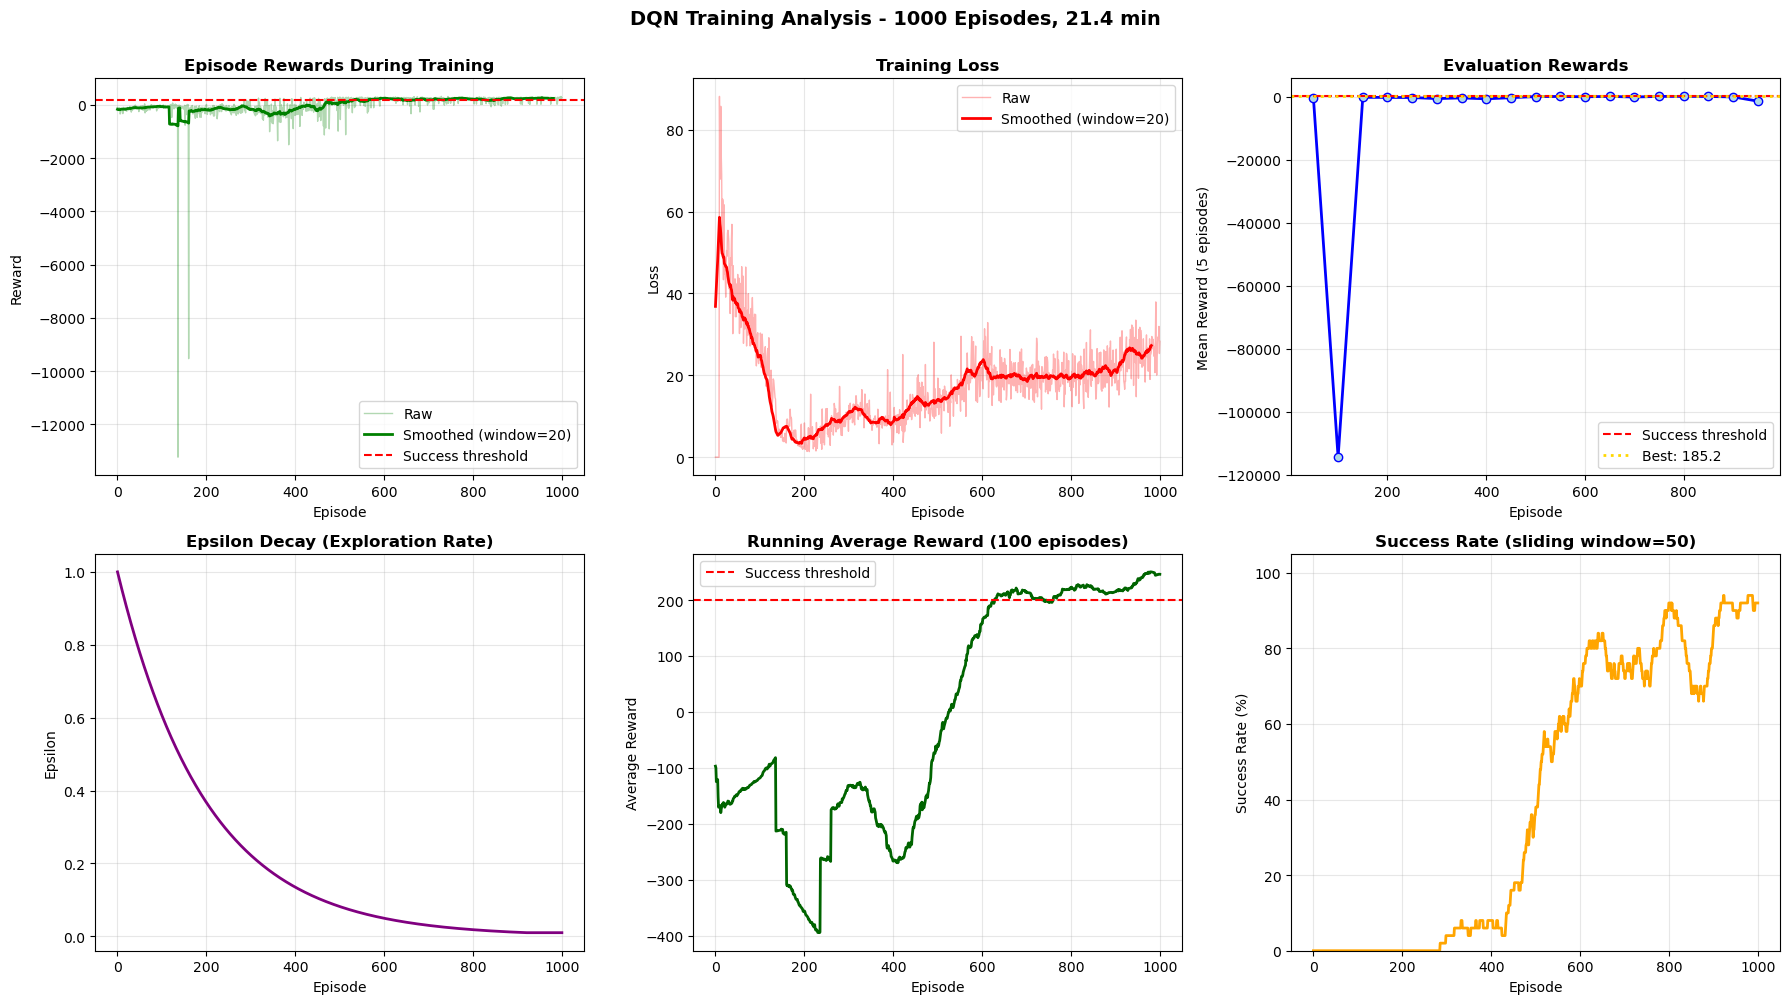

In [2]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load metrics from pickle (preserves exact data types)
pickle_path = '../results/logs/baseline_dqn_metrics.pkl'

with open(pickle_path, 'rb') as f:
    metrics = pickle.load(f)

# Extract data
loaded_episode_rewards = metrics['episode_rewards']
loaded_episode_losses = metrics['episode_losses']
loaded_eval_rewards = metrics['eval_rewards']
loaded_eval_episodes = metrics['eval_episodes']
loaded_hyperparams = metrics['hyperparams']
loaded_training_time = metrics['training_time']
loaded_best_eval = metrics['best_eval_reward']

print("✓ Metrics loaded successfully!")
print(f"  Episodes: {len(loaded_episode_rewards)}")
print(f"  Training time: {loaded_training_time/60:.2f} minutes")
print(f"  Best eval reward: {loaded_best_eval:.2f}")
print()

# Smoothing helper function
def moving_average(data, window=20):
    if len(data) < window:
        return data
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Episode Rewards (Raw + Smoothed)
axes[0, 0].plot(loaded_episode_rewards, alpha=0.3, color='green', linewidth=1, label='Raw')
smoothed_rewards = moving_average(loaded_episode_rewards, window=20)
axes[0, 0].plot(range(len(smoothed_rewards)), smoothed_rewards, color='green', linewidth=2, label='Smoothed (window=20)')
axes[0, 0].axhline(200, color='red', linestyle='--', linewidth=1.5, label='Success threshold')
axes[0, 0].set_title('Episode Rewards During Training', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training Loss (Raw + Smoothed)
axes[0, 1].plot(loaded_episode_losses, alpha=0.3, color='red', linewidth=1, label='Raw')
smoothed_losses = moving_average(loaded_episode_losses, window=20)
axes[0, 1].plot(range(len(smoothed_losses)), smoothed_losses, color='red', linewidth=2, label='Smoothed (window=20)')
axes[0, 1].set_title('Training Loss', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Evaluation Rewards
if loaded_eval_rewards:
    axes[0, 2].plot(loaded_eval_episodes, loaded_eval_rewards, marker='o', color='blue', 
                    linewidth=2, markersize=6, markerfacecolor='lightblue', markeredgecolor='blue')
    axes[0, 2].axhline(200, color='red', linestyle='--', linewidth=1.5, label='Success threshold')
    axes[0, 2].axhline(loaded_best_eval, color='gold', linestyle=':', linewidth=2, label=f'Best: {loaded_best_eval:.1f}')
    axes[0, 2].set_title('Evaluation Rewards', fontweight='bold', fontsize=12)
    axes[0, 2].set_xlabel('Episode')
    axes[0, 2].set_ylabel('Mean Reward (5 episodes)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Epsilon Decay (reconstructed)
epsilon_values = []
epsilon = loaded_hyperparams['epsilon_start']
epsilon_decay = loaded_hyperparams['epsilon_decay']
epsilon_end = loaded_hyperparams['epsilon_end']
for _ in range(len(loaded_episode_rewards)):
    epsilon_values.append(epsilon)
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

axes[1, 0].plot(epsilon_values, color='purple', linewidth=2)
axes[1, 0].set_title('Epsilon Decay (Exploration Rate)', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Epsilon')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Running Average (last 100 episodes)
running_avg = [np.mean(loaded_episode_rewards[max(0, i-99):i+1]) for i in range(len(loaded_episode_rewards))]
axes[1, 1].plot(running_avg, color='darkgreen', linewidth=2)
axes[1, 1].axhline(200, color='red', linestyle='--', linewidth=1.5, label='Success threshold')
axes[1, 1].set_title('Running Average Reward (100 episodes)', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Average Reward')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Success Rate Over Time (sliding window)
window_size = 50
success_rate = []
for i in range(len(loaded_episode_rewards)):
    start_idx = max(0, i - window_size + 1)
    window_rewards = loaded_episode_rewards[start_idx:i+1]
    rate = sum(r > 200 for r in window_rewards) / len(window_rewards) * 100
    success_rate.append(rate)

axes[1, 2].plot(success_rate, color='orange', linewidth=2)
axes[1, 2].set_title(f'Success Rate (sliding window={window_size})', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Episode')
axes[1, 2].set_ylabel('Success Rate (%)')
axes[1, 2].set_ylim([0, 105])
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'DQN Training Analysis - {len(loaded_episode_rewards)} Episodes, {loaded_training_time/60:.1f} min', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()

# Save comprehensive plot
plot_path = '../results/plots/baseline_dqn_comprehensive.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✓ Plot saved to: {plot_path}")
plt.show()

NameError: name 'episode_rewards' is not defined

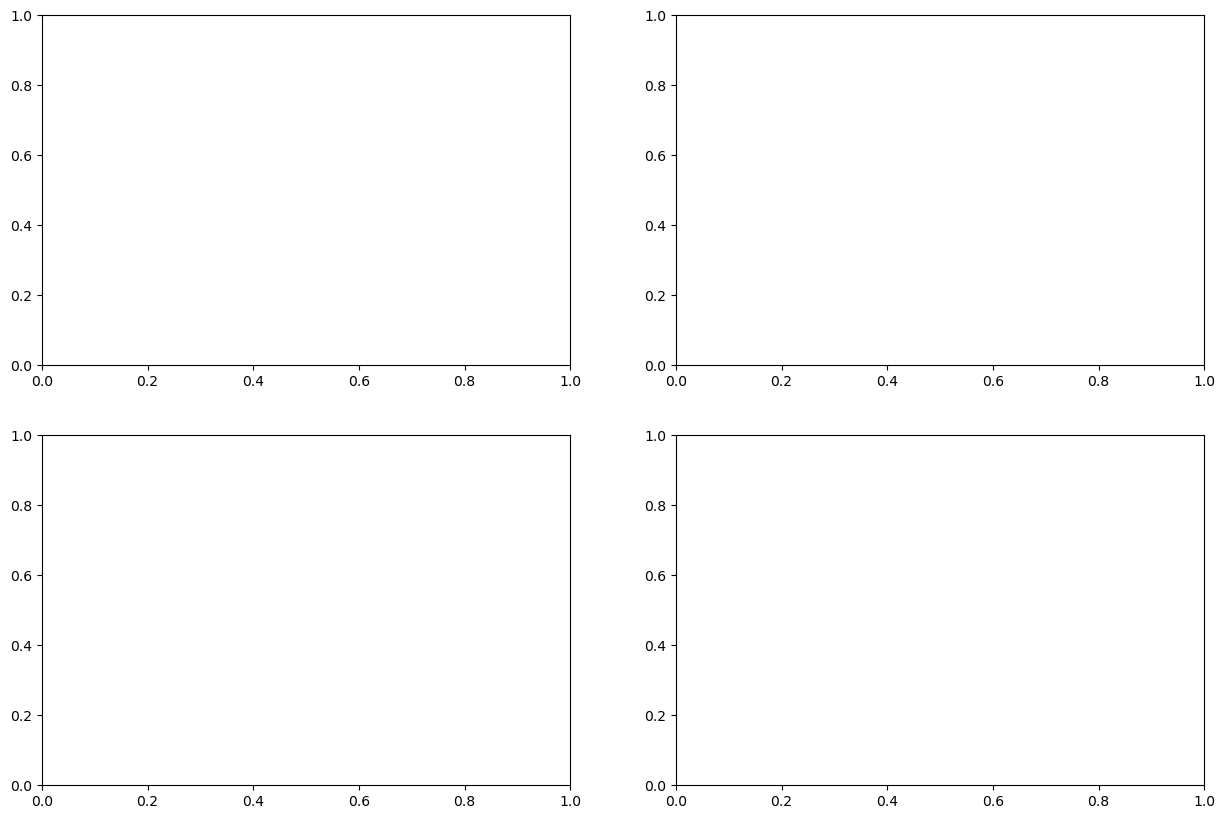

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Smoothing helper
def smooth(data, window=20):
    if len(data) < window:
        return data
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

# Plot 1: Episode Rewards
axes[0, 0].plot(episode_rewards, alpha=0.3, color='green', linewidth=1, label='Raw')
axes[0, 0].plot(smooth(episode_rewards, 20), color='green', linewidth=2, label='Smoothed (window=20)')
axes[0, 0].axhline(200, color='red', linestyle='--', label='Success threshold')
axes[0, 0].set_title('Episode Rewards During Training', fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training Loss
axes[0, 1].plot(episode_losses, alpha=0.3, color='red', linewidth=1, label='Raw')
axes[0, 1].plot(smooth(episode_losses, 20), color='red', linewidth=2, label='Smoothed')
axes[0, 1].set_title('Training Loss', fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Evaluation Rewards
if eval_rewards:
    axes[1, 0].plot(eval_episodes, eval_rewards, marker='o', color='blue', linewidth=2, markersize=6)
    axes[1, 0].axhline(200, color='red', linestyle='--', label='Success threshold')
    axes[1, 0].set_title('Evaluation Rewards', fontweight='bold')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Mean Reward (5 episodes)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Final Evaluation Distribution
axes[1, 1].hist(eval_rewards_final, bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].axvline(200, color='red', linestyle='--', linewidth=2, label='Success threshold')
axes[1, 1].axvline(np.mean(eval_rewards_final), color='blue', linestyle='-', linewidth=2, label=f'Mean: {np.mean(eval_rewards_final):.1f}')
axes[1, 1].set_title('Final Evaluation Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Reward')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/plots/baseline_full_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Analysis complete! Plots saved to results/plots/")

## Summary

### Key Takeaways:
1. **DQN successfully learns** to play Lunar Lander from scratch
2. **Exploration-exploitation tradeoff**: Epsilon decays from 1.0 (random) to 0.01 (greedy)
3. **Experience replay** breaks temporal correlations, stabilizing learning
4. **Target network** provides stable Q-targets, preventing oscillations

### Next Steps:
- **Notebook 2**: Multi-task baselines (Independent vs Shared DQN)
- **Notebook 3**: PCGrad (gradient conflict resolution)
- **Notebook 4**: VarShare (variational adapters)
- **Notebook 5**: Comprehensive analysis and comparison

---

**Congratulations!** You've successfully trained a DQN agent and are ready for multi-task learning!